# Anomaly Detection

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [18]:
data = loadmat('machine-learning-ex8/ex8/ex8data1.mat')
X = data['X']
X.shape

(307, 2)

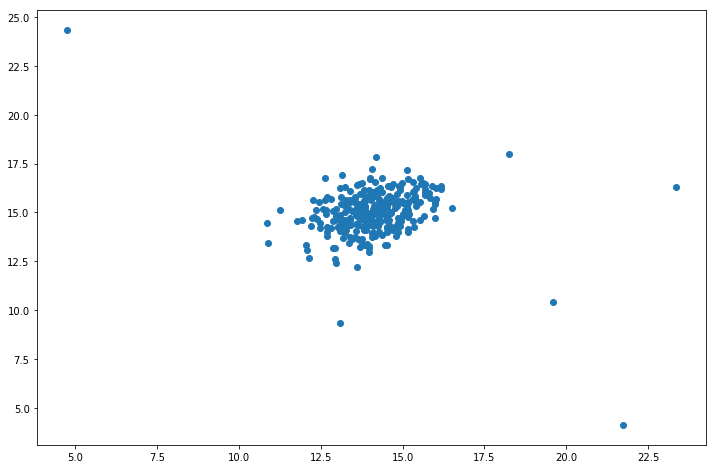

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])

## Gaussian distribution:
### Estimating parameters for a Gaussian:

In [20]:
def estimateGaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma

In [21]:
mu, sigma = estimateGaussian(X)
mu, sigma

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

### Selecting the threshold, ε:

In [22]:
Xval = data['Xval']
yval = data['yval']

Xval.shape, yval.shape

((307, 2), (307, 1))

In [23]:
from scipy import stats
dist = stats.norm(mu[0], sigma[0])
dist.pdf(X[:,0])[:10]

array([0.183842  , 0.20221694, 0.21746136, 0.19778763, 0.20858956,
       0.21652359, 0.16991291, 0.15123542, 0.1163989 , 0.1594734 ])

In [24]:
# probability distribution of the dataset
p = np.zeros(X.shape)
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

In [25]:
# probability distribution of the validation dataset
pval = np.zeros(Xval.shape)
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

In [26]:
def selectThreshold(pval, yval):
    bestEpsilon = 0;
    bestF1 = 0
    F1 = 0;
    
    step = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float).astype(float).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        P = tp / (tp + fp)
        R = tp / (tp + fn)
        F1 = (2 * P * R) / (P + R)
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    
    return bestEpsilon, bestF1        

In [27]:
epsilon, F1 = selectThreshold(pval, yval)
epsilon, F1

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


(0.009566706005956842, 0.7142857142857143)

In [28]:
# indexes of the outliers
outliers = np.where(p < epsilon)
outliers

(array([300, 301, 301, 303, 303, 304, 306, 306]),
 array([1, 0, 1, 0, 1, 0, 0, 1]))

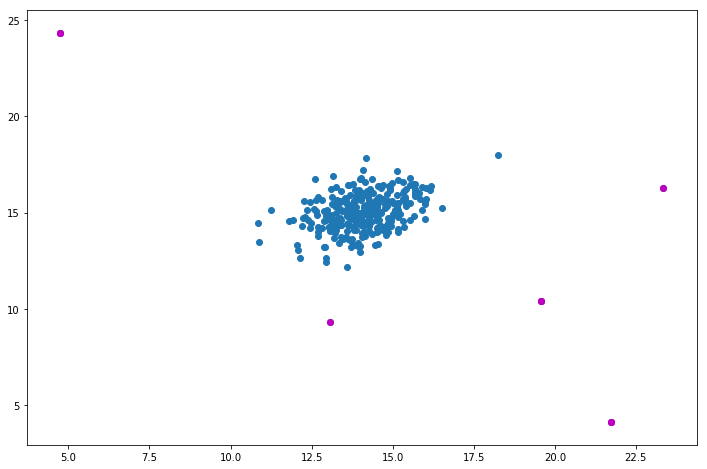

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], color='m')

# Recommender Systems:
### Movie ratings dataset:

In [30]:
data = loadmat('machine-learning-ex8/ex8/ex8_movies.mat')
data

{'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0'}

In [31]:
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

In [50]:
# average rating of 2nd movie is
Y[1, np.where(R[1,:] == 1)[0]].mean()

3.2061068702290076

Text(0,0.5,'Movies')

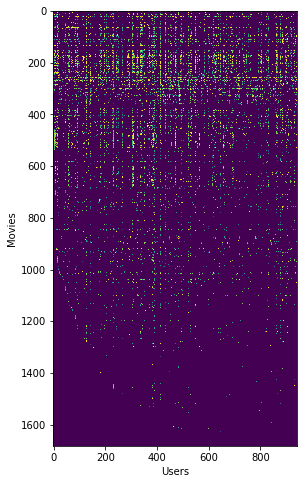

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')

## Collaborative filtering learning algorithm:
### Collaborative filtering cost function:

In [57]:
def cost(params, Y, R, n):
    Y = np.matrix(Y)
    R = np.matrix(R)
    nm = Y.shape[0]
    nu = Y.shape[1]
    
    X = np.matrix(np.reshape(params[:nm * n], (nm, n)))
    theta = np.matrix(np.reshape(params[nm * n:], (nu, n)))
    
    J = (1/2) * np.sum(np.power(np.multiply((X * theta.T) - Y, R), 2))
    
    return J

In [61]:
paramsData = loadmat('machine-learning-ex8/ex8/ex8_movieParams.mat')
X = paramsData['X']
theta = paramsData['Theta']
X.shape, theta.shape

((1682, 10), (943, 10))

In [78]:
nu = 4
nm = 5
n = 3
X_sub = X[:nm, :n]
theta_sub = theta[:nu, :n]
Y_sub = Y[:nm, :nu]
R_sub = R[:nm, :nu]

params = np.concatenate((X_sub.ravel(), theta_sub.ravel()))

cost(params, Y_sub, R_sub, n)

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

### Collaborative filtering gradient:

In [75]:
def cost(params, Y, R, n):
    Y = np.matrix(Y)
    R = np.matrix(R)
    nm = Y.shape[0]
    nu = Y.shape[1]
    
    # unroll parameters
    X = np.matrix(np.reshape(params[:nm * n], (nm, n)))
    theta = np.matrix(np.reshape(params[nm * n:], (nu, n)))
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    theta_grad = np.zeros(theta.shape)
    
    error = np.multiply((X * theta.T) - Y, R)
    
    J = (1/2) * np.sum(np.power(error, 2))
    
    X_grad = error * theta
    theta_grad = error.T * X
    
    grad = np.concatenate((np.ravel(X_grad), np.ravel(theta_grad)))
    
    return J, grad

In [76]:
J, grad = cost(params, Y_sub, R_sub, n)
J, grad

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

### Regularized cost function:

In [79]:
def cost(params, Y, R, n, lam):
    Y = np.matrix(Y)
    R = np.matrix(R)
    nm = Y.shape[0]
    nu = Y.shape[1]
    
    # unroll parameters
    X = np.matrix(np.reshape(params[:nm * n], (nm, n)))
    theta = np.matrix(np.reshape(params[nm * n:], (nu, n)))
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    theta_grad = np.zeros(theta.shape)
    
    error = np.multiply((X * theta.T) - Y, R)
    
    J = (1/2) * np.sum(np.power(error, 2))
    
    # add regularization to the cost
    J += (lam/2) * np.sum(np.power(theta, 2))
    J += (lam/2) * np.sum(np.power(X, 2))
    
    # gradients with regularization
    X_grad = error * theta + (lam * X)
    theta_grad = error.T * X + (lam * theta)
    
    grad = np.concatenate((np.ravel(X_grad), np.ravel(theta_grad)))
    
    return J, grad

In [80]:
J, grad = cost(params, Y_sub, R_sub, n, 1.5)
J, grad

(31.34405624427422,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

## Learning movie recommendations:

In [91]:
movie_idx = {}
f = open('machine-learning-ex8/ex8/movie_ids.txt')
for line in f:
    s = line.split(' ')
    s[-1] = s[-1][:-1]
    movie_idx[int(s[0]) - 1] = ' '.join(s[1:])

In [92]:
movie_idx[0]

'Toy Story (1995)'

In [94]:
# create our own ratings for some movies
ratings = np.zeros((1682, 1))

ratings[0] = 5
ratings[63] = 5
ratings[68] = 5

print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[63]))))

Rated Toy Story (1995) with 5 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated Forrest Gump (1994) with 5 stars.


In [95]:
# add our own ratings vector to the existing data
R = np.append(data['R'], ratings != 0, axis=1)
Y = np.append(data['Y'], ratings, axis=1)

Y.shape, R.shape

((1682, 944), (1682, 944))

In [102]:
nm = Y.shape[0]
nu = Y.shape[1]
n = 10
lam = 10

params = np.random.random(size=((nm * n) + (nu * n),))

params.shape

(26260,)

In [103]:
# normalize the ratings (Y - mu)
Ymean = np.zeros((nm, 1))
Ynorm = np.zeros((nm, nu))

for i in range(nm):
    idx = np.where(R[i,:] == 1)[0]
    Ymean[i] = Y[i,idx].mean()
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]

In [104]:
# minimize the cost function
from scipy.optimize import minimize

fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, n, lam), method='CG', jac=True, options={'maxiter': 100})

fmin

     fun: 38970.80995695868
     jac: array([-0.21624453, -0.39736421, -0.22766823, ...,  0.01078863,
       -0.01019731,  0.00483273])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 156
     nit: 100
    njev: 156
  status: 1
 success: False
       x: array([ 0.58802966, -0.19909935, -0.2288541 , ...,  0.06169603,
       -0.10768292,  0.00061393])

In [105]:
# unfold the parameters
X = np.matrix(np.reshape(fmin.x[:nm * n], (nm, n)))
theta = np.matrix(np.reshape(fmin.x[nm * n:], (nu, n)))

In [106]:
predictions = X * theta.T
myPredictions = predictions[:, -1] + Ymean
myPredictions.shape

(1682, 1)

In [111]:
# get top 10 recommendations
sortedPreds = np.sort(myPredictions, axis=0)[::-1]
sortedPreds[:10]

matrix([[5.00000118],
        [4.99999985],
        [4.99999929],
        [4.99999922],
        [4.99999894],
        [4.99999848],
        [4.99999842],
        [4.99999803],
        [4.99999733],
        [4.99999597]])

In [113]:
# need to get the indeces instead of ratings
idx = np.argsort(myPredictions, axis=0)[::-1]
idx[:10]

matrix([[1200],
        [1499],
        [1292],
        [1121],
        [1652],
        [1535],
        [ 813],
        [1188],
        [1466],
        [1598]])

In [132]:
int(idx[0]), idx[0]

(1200, matrix([[1200]]))

In [131]:
# get the movies names from the indeces
for i in range(10):
    j = int(idx[i])
    print('%d.) %s with predicted rating of %0.2f\n'% (i+1, movie_idx[j], myPredictions[j]))

1.) Marlene Dietrich: Shadow and Light (1996)  with predicted rating of 5.00

2.) Santa with Muscles (1996) with predicted rating of 5.00

3.) Star Kid (1997) with predicted rating of 5.00

4.) They Made Me a Criminal (1939) with predicted rating of 5.00

5.) Entertaining Angels: The Dorothy Day Story (1996) with predicted rating of 5.00

6.) Aiqing wansui (1994) with predicted rating of 5.00

7.) Great Day in Harlem, A (1994) with predicted rating of 5.00

8.) Prefontaine (1997) with predicted rating of 5.00

9.) Saint of Fort Washington, The (1993) with predicted rating of 5.00

10.) Someone Else's America (1995) with predicted rating of 5.00

